#### Raw Data
1. 12 time points from [0, 1, 1.5, 2, 2.5, 3, 4, 5, 5.5, 6, 7, 8] hr of L1210 cell cycle.

#### Get_binned_counts.sh
1. Creates counts.bed file that contains read count for each 10000bp window with step size 5000 for each time point.

#### Python Notebook
1. Gets Zscore (mean 0, SD 1) from counts.bed file for each time point;
2. Restricts region on chr2 between 50,000,000 and 90,000,000 bp;
3. Smoothes data by getting the center value in +/- 10 windows for each position for each time point;
4. Plots combined and separated figures with smoothed data.

In [1]:
%pylab inline
import matplotlib.pyplot as plt
import pandas as pd
import scipy.interpolate
import scipy.stats
import matplotlib as mpl
import errno
import sys
mpl.rcParams['pdf.fonttype'] = 42

Populating the interactive namespace from numpy and matplotlib


### Helper functions

In [2]:
# Restrict to region from mccarroll paper
Mb = 1000000
minval = 50
maxval = 90
time = [1,1.5,2,2.5,3,4,5,5.5,6,7,8]

# read from our experiment data
def read_data(exp, histone):
    print(exp)
    data_array=[]
    if exp=="exp1":
        suffix_1 = 'HJW7KBGXX'
        suffix_2 = 'HHF3MBGXX'
    else:
        suffix_1 = 'HJWMVBGXX'
        suffix_2 = 'HJW7KBGXX'
    
    sample_background = pd.read_csv("./counts/"+exp+"_0hr_WCE_"+suffix_1+".dupsRemoved.merged.sorted.counts.bed", sep="\t", names=["chrom","start","end","readcount"])
    sample_background["zscore"] = GetZscore(sample_background, "readcount")
    
    stats = open("log/"+exp+"_ratio_stats.log",'w') # write 
    
    for i in [1,1.5,2,2.5,3,4,5,5.5,6,7,8]:
        try:
            data = pd.read_csv("./counts/"+exp+"_"+str(i)+"hr_WCE_"+suffix_1+".dupsRemoved.merged.sorted.counts.bed", sep="\t", names=["chrom","start","end","readcount"])
        except FileNotFoundError:
            data = pd.read_csv("./counts/"+exp+"_"+str(i)+"hr_WCE_"+suffix_2+".dupsRemoved.merged.sorted.counts.bed", sep="\t", names=["chrom","start","end","readcount"])
        
        data = data[(data["start"]>=minval*Mb) & (data["start"]<=maxval*Mb)]

        data = get_ratio(data, sample_background,i, stats)
        
        data_array.append((data, exp+"_"+str(i)+"hr_WCE"))
    return data_array

# Get zscore
def GetZscore(data, col):
    m = np.mean(data[col])
    s = np.sqrt(np.var(data[col]))
    return data.apply(lambda x: (x[col]-m)/s, 1)    

# get ratio of readcount in data and background 
def get_ratio(data, background, i, stats=0):
    data["ratio"] = data["readcount"]/background['readcount']

    m = np.mean(data["ratio"])
    s = np.sqrt(np.var(data["ratio"]))
    
    if stats != 0:
        [stats.write(str(w)) for w in [i, m, m+3*s, m-3*s]]
        stats.write('\n')
    print(i, m, m+3*s, m-3*s)
    
    # get rid of extrme values
    data = data[data["ratio"]<=m+3*s]
    data = data[data["ratio"]>=m-3*s] 

    data["zscore"] = GetZscore(data, "ratio")
    return data


## Read bed file of 12 time points and references
1. In bed files the step sizes are not equal for some positions
        e.g -- 52515000 in 1hr
   

In [3]:
# load our data
data_array_exp1 = read_data('exp1')
data_array_exp2 = read_data('exp2')

ref_array = []
ref_header = ["Simon-rep1-G1", "Simon-rep1-S","Simon-rep2-G1", "Simon-rep2-S"]

# load Itamar's rep1
rep1_G1 = pd.read_csv("./counts/merged_4_G1.nodups.counts.bed",sep="\t", names=["chrom","start","end","readcount"])
rep1_S = pd.read_csv("./counts/merged_4_S.nodups.counts.bed",sep="\t", names=["chrom","start","end","readcount"])
rep1_S = get_ratio(rep1_S, rep1_G1, ref_header[1])

# load Itamar's rep2
rep2_G1 = pd.read_csv("./counts/merged_5_G1.nodups.counts.bed",sep="\t", names=["chrom","start","end","readcount"])
rep2_S = pd.read_csv("./counts/merged_5_S.nodups.counts.bed",sep="\t", names=["chrom","start","end","readcount"])
rep2_S = get_ratio(rep2_S, rep2_G1, ref_header[3])


exp1
1 0.548622222702 1.48347599107 -0.386231545664
1.5 1.27299981352 2.38877540139 0.157224225658
2 0.946287015164 1.85821427722 0.0343597531042
2.5 0.885280019791 1.73818381638 0.0323762232017
3 0.242860197429 0.778952373827 -0.293231978969
4 0.76182986461 1.54970825486 -0.0260485256439
5 0.311581218701 1.07900199899 -0.455839561589
5.5 2.29349827117 4.28873372291 0.298262819424
6 0.895779780824 1.77765597871 0.0139035829375
7 0.822569890877 1.62262985006 0.022509931694
8 0.34402719751 1.02086802452 -0.332813629499
exp2
1 0.987626955338 1.58368553262 0.391568378053
1.5 1.09784507783 1.8470828135 0.348607342159
2 0.969836752925 1.87595307314 0.0637204327084
2.5 0.906245645218 1.71963874283 0.092852547606
3 0.925178632895 1.5597911002 0.290566165592
4 0.932484777448 1.72972973463 0.135239820267
5 0.755765246403 1.39545738731 0.116073105499
5.5 0.967961703219 1.73293980844 0.202983597996
6 0.855380515314 1.45565352385 0.255107506777
7 1.05797925226 1.7245120783 0.391446426222
8 0.946027

## Get smoothed x and y values in 12 samples and reference

In [9]:
def new_smooth(data, window_size = 100000, stepsize = 50000, column = "zscore"):
    newx = []
    newy = []
    i = minval*Mb
    while i < maxval *Mb-stepsize:
        center = i+stepsize
        x = data[(data['start']>=i) & (data['end'] <= i+window_size)]
        i += stepsize
        newx.append(center)
        newy.append(np.mean(x[column]))
    return np.array(newx), np.array(newy)

In [ ]:
WINDOWSTEP=5000
def Smooth(data, windows=20, column="zscore", thin=10):
    newx = []
    newy = []
#     print(data.shape[0])
    # For each x, get +/- 10 windows
    for i in range(data.shape[0]):
        center = data.start.values[i]
        beginwindow = center - windows/2*WINDOWSTEP
        endwindow = center + (windows/2+1)*WINDOWSTEP
        x = data[(data["start"]>=beginwindow) & (data["end"]<=endwindow)]
#         print(center, beginwindow, endwindow)
#         if x.shape[0] == windows:
#             newx.append(center)
#             newy.append(np.mean(x[column]))
#         else:
#             newx.append(np.nan)
#             newy.append(np.nan)
        newx.append(center)
        newy.append(np.sum(x['readcount']))
#     ind = [i for i in range(len(newx)) if i%thin == 0]
#     return np.array(newx)[ind], np.array(newy)[ind]
    return np.array(newx), np.array(newy)

In [17]:
xarray_exp1 = []
yarray_exp1 = []
xarray_exp2 = []
yarray_exp2 = []

# smooth exp1
for data in data_array_exp1:
    xnew, ynew = new_smooth(data[0])
    xarray_exp1.append(xnew)
    yarray_exp1.append(ynew)

# smooth exp2
for data in data_array_exp2:
    xnew, ynew = new_smooth(data[0])
    xarray_exp2.append(xnew)
    yarray_exp2.append(ynew)

# smooth Itamar's data
rep1_x, rep1_y = new_smooth(rep1_S)
rep2_x, rep2_y = new_smooth(rep2_S)

In [11]:
# size validation
for x in xarray_exp1:
    print(x.shape)
for x in xarray_exp2:
    print(x.shape)
print(rep1_x.shape)
print(rep1_y.shape)

(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)
(799,)


[]

## Plot all figures together

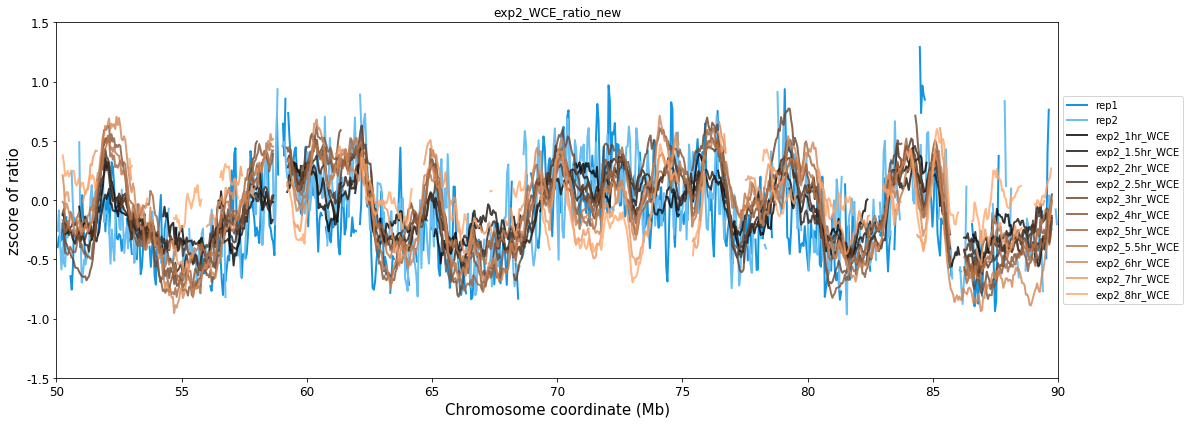

In [9]:
fig = plt.figure()
lines = []

ax = fig.add_subplot(111)
# Plot koren
# ax.plot(koren["start"], koren["zscore"], color="blue", lw=2)

# plot reference
# ax.plot(gilbert["start"], gilbert["zscore"], color="#0050c9", lw=2, label="gilbert")
# ax.plot(rep1["start"], rep1["zscore"], color="#197f94", lw=2, label="rep1")
# ax.plot(rep2["start"], rep2["zscore"], color="#19b3cb", lw=2, label="rep2")
ax.set_title("exp2_WCE_ratio_new")
ax.plot(list(rep1_x), list(rep1_y), color="#1495e1", lw=2, label="rep1")
ax.plot(list(rep2_x), list(rep2_y), color="#69bff2", lw=2, label="rep2")
i = 0
line_width = 2
for data in data_array:
#     if i == 1:
#         line_width = 3
#     else:
#         line_width = 2
        
    xnew, ynew = xarray[i],yarray[i]
    
    # get color scheme
    jet = cm = plt.get_cmap('copper') 
    
    cNorm  = mpl.colors.Normalize(vmin=0, vmax=12)
    scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=jet)
#     print scalarMap.get_clim()

    colorVal = scalarMap.to_rgba(i)
    colorText = ('color: (%4.2f,%4.2f,%4.2f)'%(colorVal[0],colorVal[1],colorVal[2]))
    retLine, = ax.plot(list(xnew),list(ynew),color=colorVal,label=data[1], linewidth = line_width, alpha = 0.8)
    lines.append(retLine)
    i+=1

# ax.plot(list(xnew), list(ynew), color="black", lw=2)
# ax.scatter(data[0]["start"], data[0]["zscore"], color="gray", alpha=0.1)
ax.set_xlim(left=minval*Mb, right=maxval*Mb);
ax.set_ylim(bottom=-1.5, top=1.5)
ax.set_xlabel("Chromosome coordinate (Mb)", size=15);
ax.set_ylabel("zscore of ratio", size=15);
ax.set_xticklabels(map(lambda x: int(x/Mb), ax.get_xticks()), size=12);
ax.set_yticklabels(ax.get_yticks(), size=12);
handles,labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels,loc='center left', bbox_to_anchor=(1, 0.5))

fig.set_size_inches(15,6, forward=True)
fig.tight_layout()
# fig.savefig("exp1_WCE_combined.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig("exp2_WCE_ratio_new_combined.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

## Plot figures seperately

0
1
2
3
4
5
6
7
8
9
10


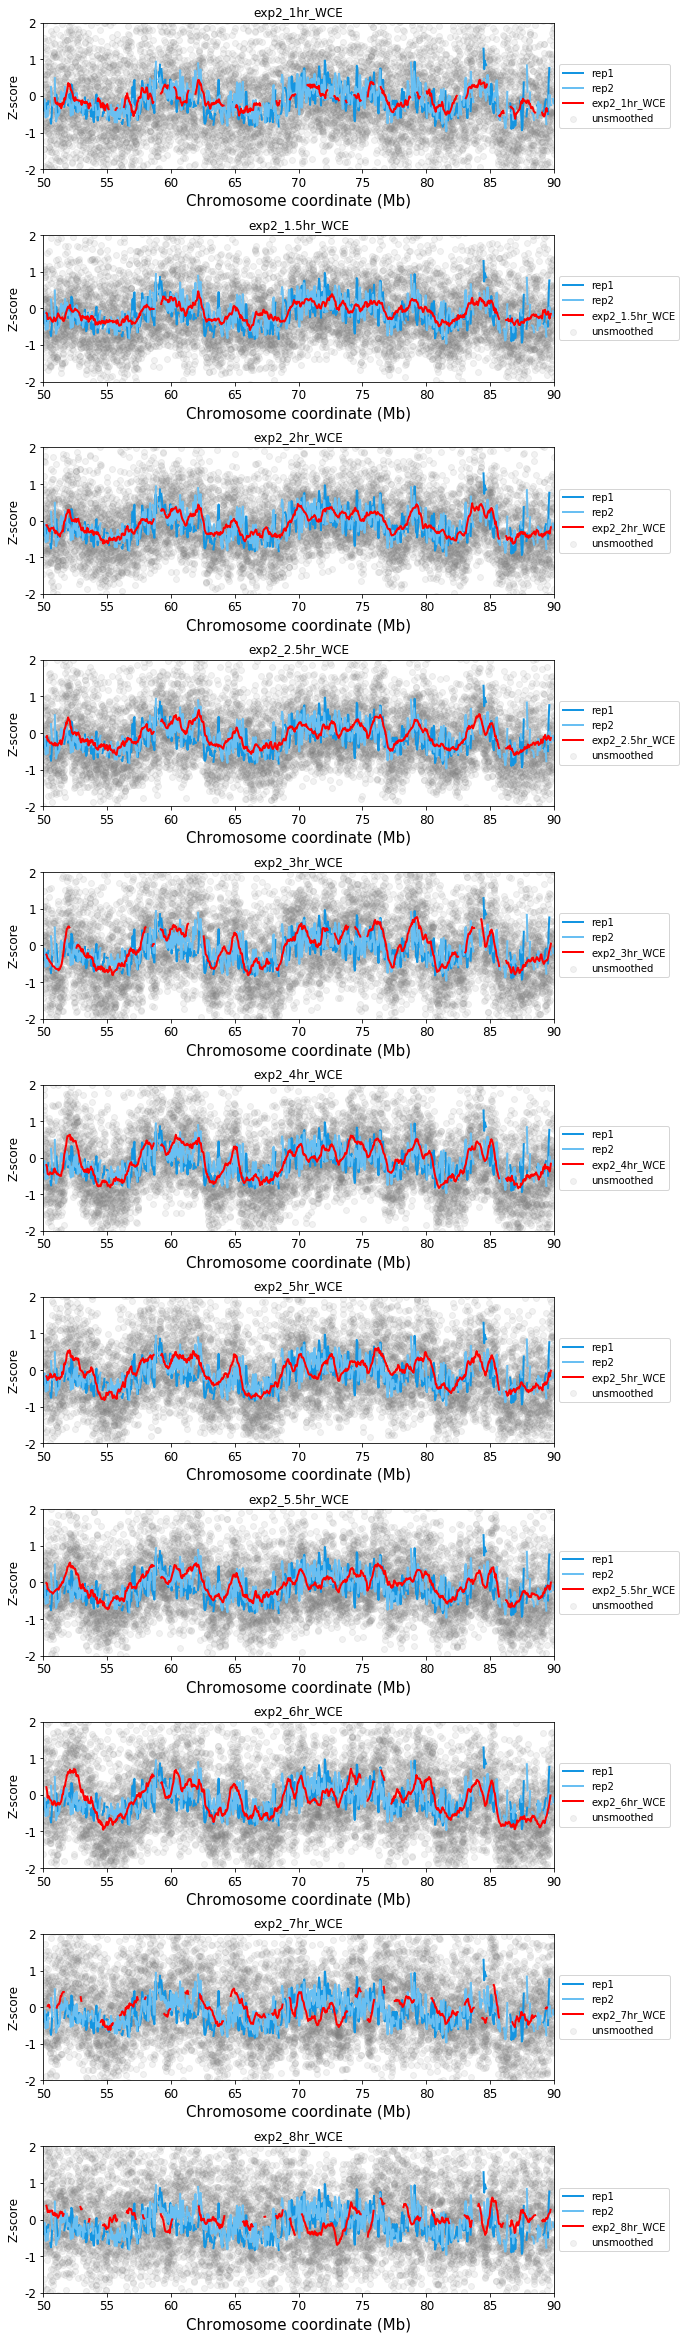

In [8]:

fig = plt.figure()
# Plot koren
# ax.plot(koren["start"], koren["zscore"], color="blue", lw=2)

i = 0
for data in data_array:
    print(i)
    xnew, ynew = xarray[i],yarray[i]

    ax = fig.add_subplot(12,1,i+1)
    ax.set_title(data[1])


    # plot reference
#     ax.plot(gilbert["start"], gilbert["zscore"], color="#1076b2", lw=2, label="gilbert")
#     ax.plot(rep1["start"], rep1["zscore"], color="#1495e1", lw=2, label="rep1")
#     ax.plot(rep2["start"], rep2["zscore"], color="#69bff2", lw=2, label="rep2")
    ax.plot(list(rep1_x), list(rep1_y), color="#1495e1", lw=2, label="rep1")
    ax.plot(list(rep2_x), list(rep2_y), color="#69bff2", lw=2, label="rep2")

    # plot data
    ax.scatter(data[0]["start"], data[0]["zscore"], color="gray", label="unsmoothed", alpha=0.1)
    ax.plot(list(xnew),list(ynew),color="red",lw=2, label=data[1])
    i+=1

    # ax.plot(list(xnew), list(ynew), color="black", lw=2)

    ax.set_xlim(left=minval*Mb, right=maxval*Mb);
    ax.set_ylim(bottom=-2, top=2)
    ax.set_xlabel("Chromosome coordinate (Mb)", size=15);
    ax.set_ylabel("Z-score", size=12);
    ax.set_xticklabels(map(lambda x: int(x/Mb), ax.get_xticks()), size=12);
    ax.set_yticklabels(range(-2,3,1), size=12);
    handles,labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels,loc='center left', bbox_to_anchor=(1, 0.5))

fig.set_size_inches(8,35, forward=True)
fig.tight_layout()
# fig.savefig("exp1_WCE_separate.pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig("exp2_WCE_ratio_new_separate.pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')

## Ratio Plot

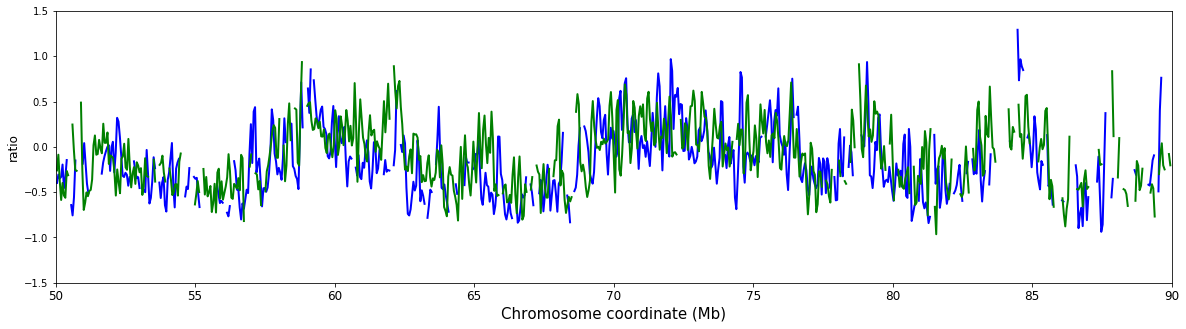

In [29]:
# rep1 and rep2
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(rep1_x, rep1_y, color="blue", lw=2)
ax.plot(rep2_x, rep2_y, color="green", lw=2)

ax.set_xlim(left=minval*Mb, right=maxval*Mb);
ax.set_ylim(bottom=-1.5, top=1.5)
ax.set_xlabel("Chromosome coordinate (Mb)", size=15);
ax.set_ylabel("ratio", size=12);
ax.set_xticklabels(map(lambda x: int(x/Mb), ax.get_xticks()), size=12);

fig.set_size_inches(20,5, forward=True)

## Correlation Graph


(-0.1, 0.6)

/usr/lib64/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


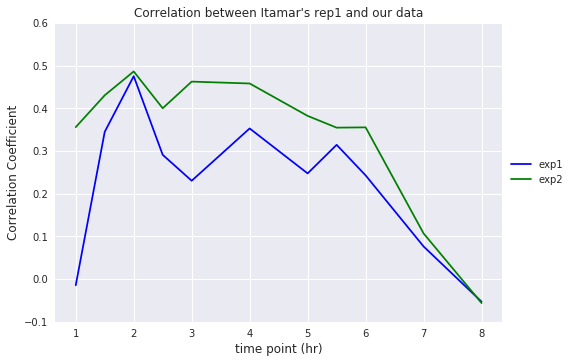

In [106]:
corr_exp1 = ([],[])
corr_exp2 = ([],[])

# calculate pearson correlation
for i in range(len(yarray_exp1)):
    corr_exp1[0].append(time[i])
    corr_exp1[1].append(scipy.stats.pearsonr(rep1_y, yarray_exp1[i])[0])
#     corr_exp1[1].append(scipy.stats.spearmanr(rep1_y, yarray_exp1[i])[0])
    
for i in range(len(yarray_exp2)):
    corr_exp2[0].append(time[i])
    corr_exp2[1].append(scipy.stats.pearsonr(rep1_y, yarray_exp2[i])[0])
#     corr_exp2[1].append(scipy.stats.spearmanr(rep1_y, yarray_exp2[i])[0])
    
    
# plot correlations
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Correlation between Itamar's rep1 and our data")

ax.plot(corr_exp1[0], corr_exp1[1], color = 'blue',label = 'exp1')
ax.plot(corr_exp2[0], corr_exp2[1], color = 'green', label = 'exp2')

ax.set_xlabel("time point (hr)", size=12)
ax.set_ylabel("Correlation Coefficient", size=12)

handles,labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels,loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_ylim(bottom=-0.1, top=0.6)
    

In [172]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict

d_b = OrderedDict({})
d_1 = OrderedDict({})
d_2 = OrderedDict({})

for i in range(len(yarray_exp1)):
    if i == 4 or i ==6:
        continue
    d_b['exp1_'+str(time[i])] = yarray_exp1[i]
    d_b['exp2_'+str(time[i])] = yarray_exp2[i]
corr_df_both = pd.DataFrame(d_b).corr()

for i in range(len(yarray_exp1)):
    if i == 4 or i ==6:
        continue
    d_1['exp1_'+str(time[i])] = yarray_exp1[i]
corr_df_exp1 = pd.DataFrame(d_1).corr()

for i in range(len(yarray_exp1)):
    d_2['exp2_'+str(time[i])] = yarray_exp2[i]
corr_df_exp2 = pd.DataFrame(d_2).corr()

/usr/lib64/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


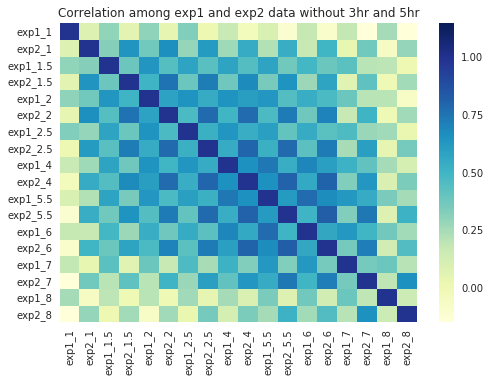

In [173]:
axb = sns.heatmap(corr_df_both,center=0.5, cmap="YlGnBu")
axb.set_title("Correlation among exp1 and exp2 data without 3hr and 5hr")

/usr/lib64/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


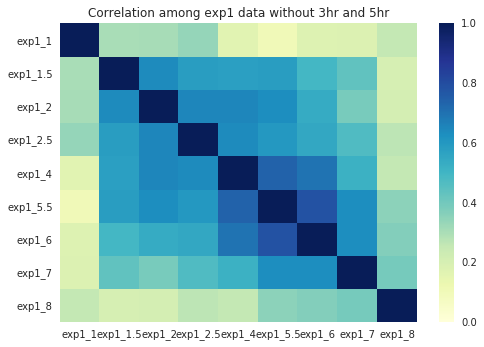

In [169]:
ax1 = sns.heatmap(corr_df_exp1,center=0.5, cmap="YlGnBu")
ax1.set_title("Correlation among exp1 data without 3hr and 5hr")

/usr/lib64/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


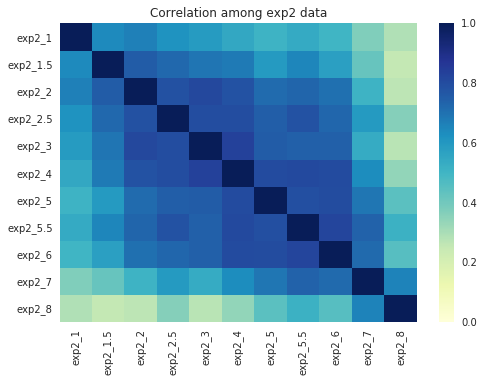

In [144]:
ax2 = sns.heatmap(corr_df_exp2,cmap="YlGnBu",center=0.5)
ax2.set_title("Correlation among exp2 data")

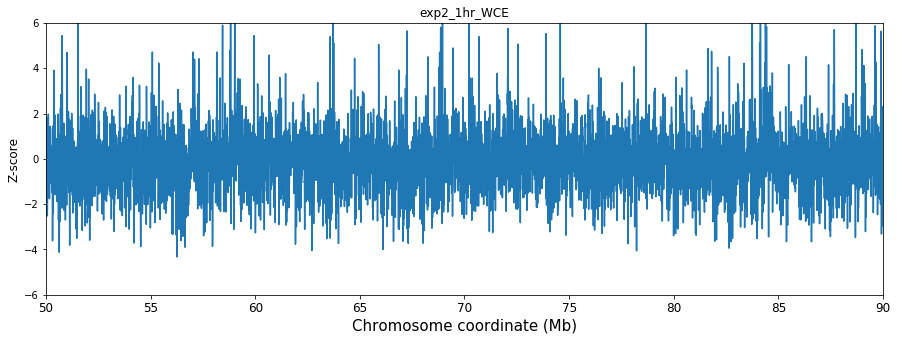

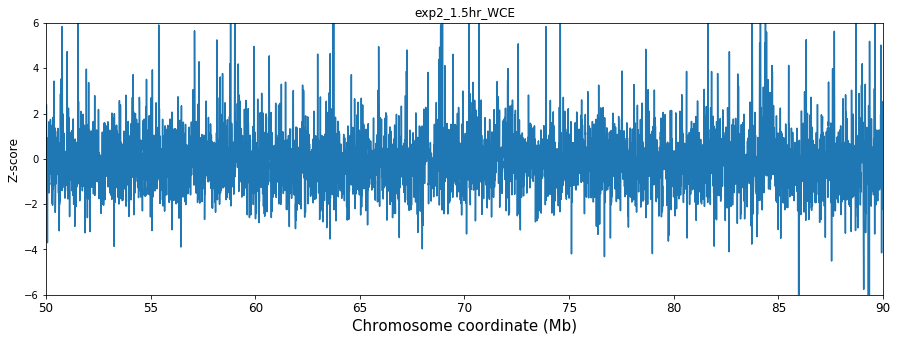

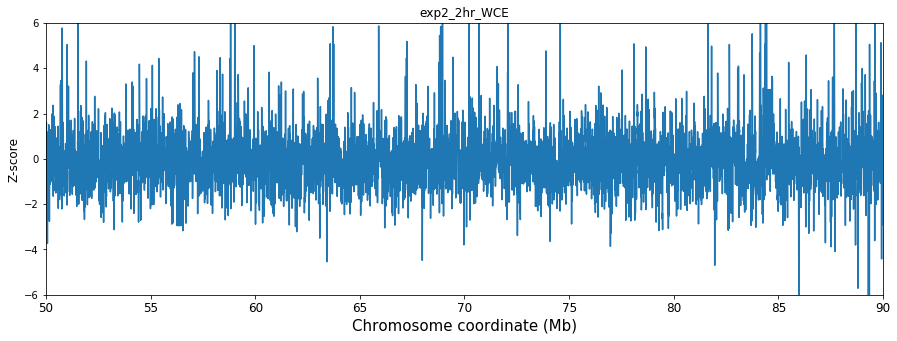

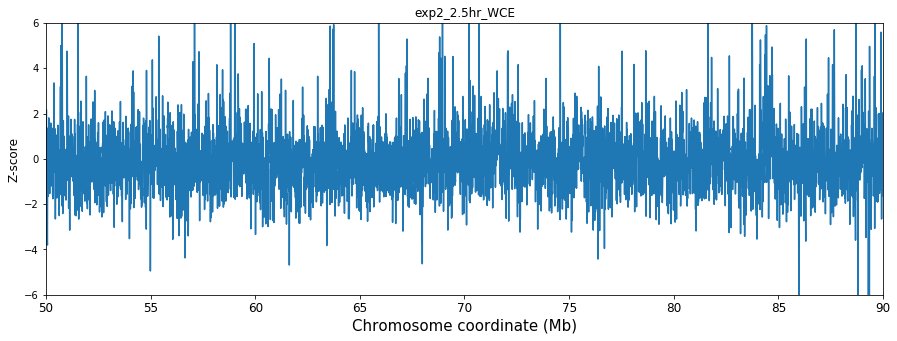

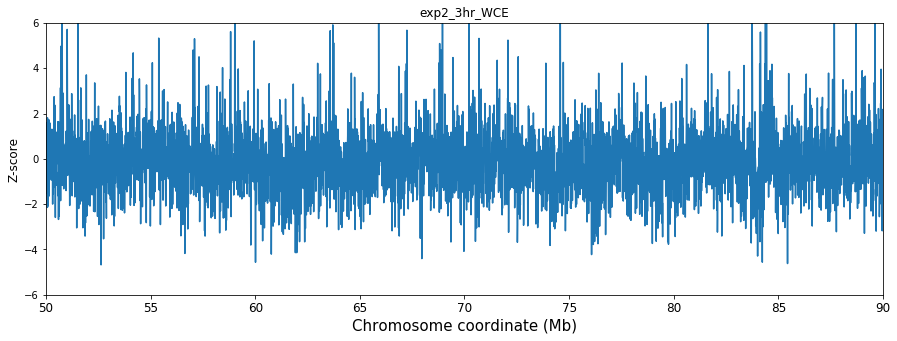

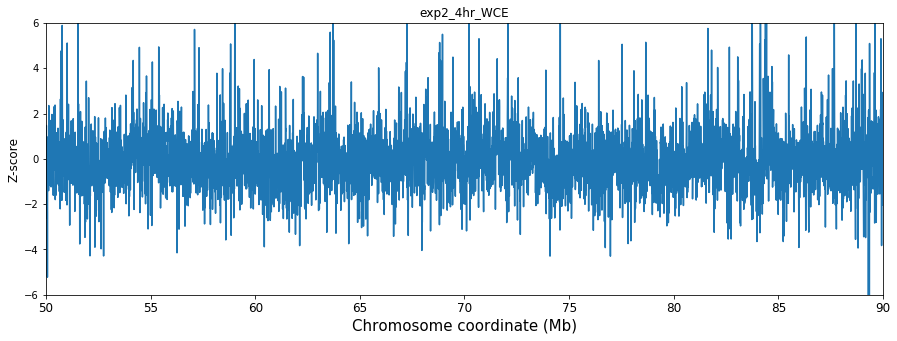

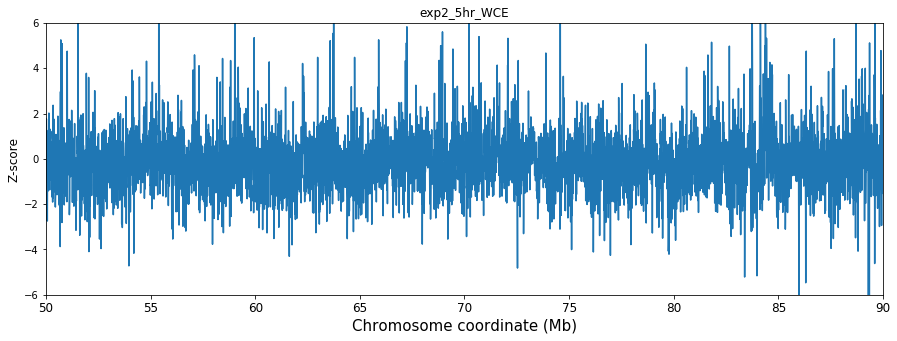

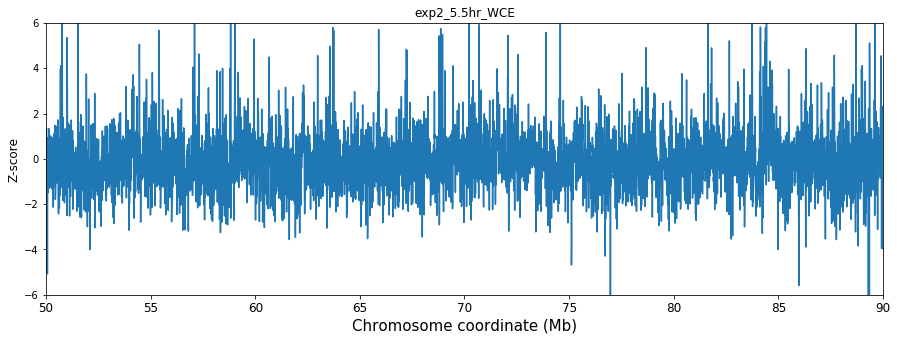

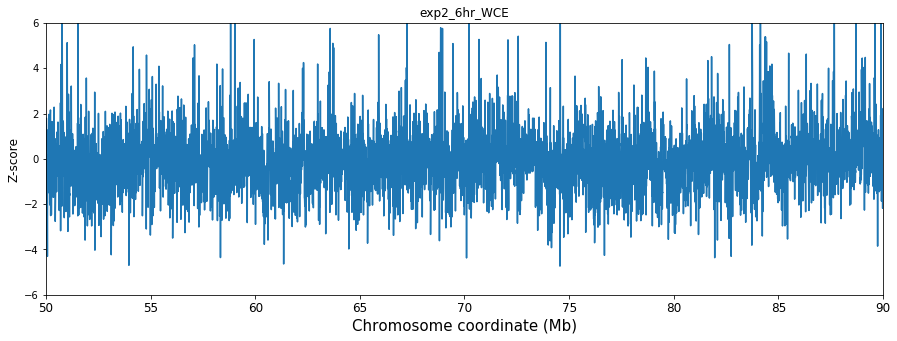

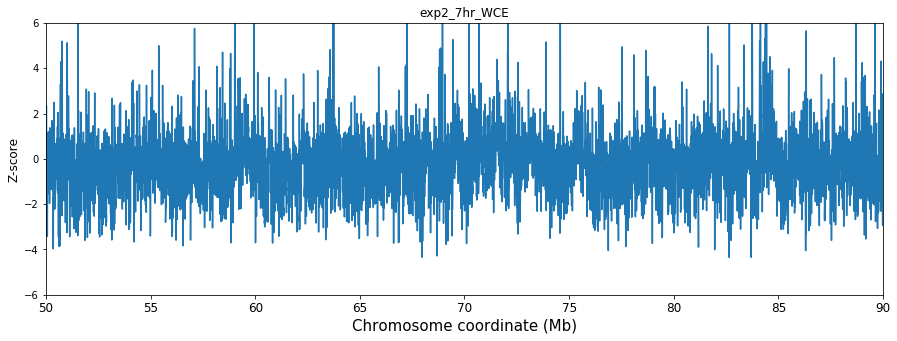

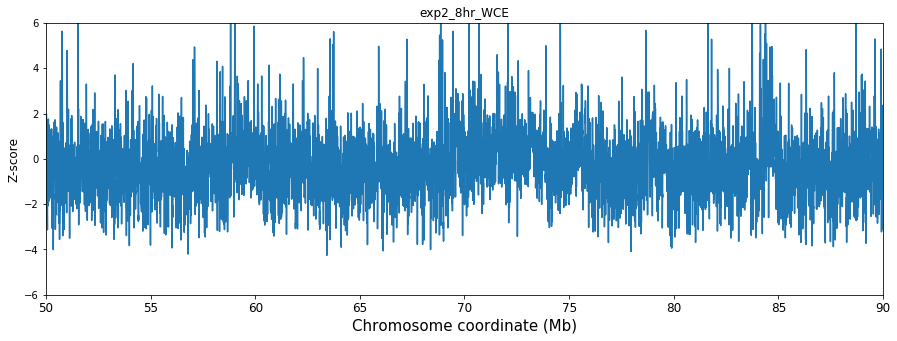

In [61]:
# unsmoothed
for data in data_array:
    r2 = rep1_S.set_index('start').join(data[0].set_index('start'), lsuffix='_rep1', rsuffix='_1hr').dropna()
    r2['res'] = r2['zscore_rep1']-r2['zscore_1hr']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(data[1])
    ax.plot(r2.index,r2['res'])
    ax.set_xlim(left=minval*Mb, right=maxval*Mb);
    ax.set_ylim(bottom=-6, top=6)
    ax.set_xlabel("Chromosome coordinate (Mb)", size=15);
    ax.set_ylabel("Z-score", size=12);
    ax.set_xticklabels(map(lambda x: int(x/Mb), ax.get_xticks()), size=12);
    fig.set_size_inches(15,5, forward=True)

## Distribution Histogram

1. Distribution of rep1 and rep2 are not standard distribution

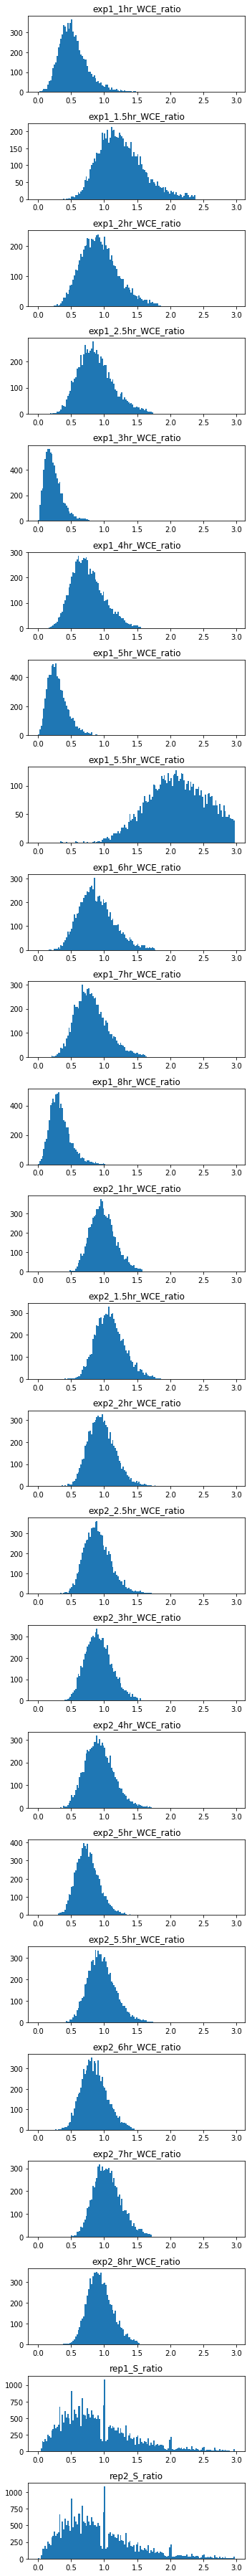

In [11]:
fig = plt.figure()

i = 0
for data in data_array_exp1:
    ax = fig.add_subplot(24,1,i+1)
    ax.title.set_text(data[1]+'_ratio')
    ax.hist(data[0]["ratio"], bins=np.arange(0, 3, 0.02))
    i+=1
    
#     ax = fig.add_subplot(42,1,i+1)
#     ax.title.set_text(data[1]+'_zscore')
#     ax.hist(data[0]["zscore"], bins = np.arange(-4, 4, 0.05));
#     i+=1

for data in data_array_exp2:
    ax = fig.add_subplot(24,1,i+1)
    ax.title.set_text(data[1]+'_ratio')
    ax.hist(data[0]["ratio"], bins=np.arange(0, 3, 0.02))
    i+=1
    
#     ax = fig.add_subplot(44,1,i+1)
#     ax.title.set_text(data[1]+'_zscore')
#     ax.hist(data[0]["zscore"], bins = np.arange(-4, 4, 0.05));
#     i+=1
    
# rep1
ax = fig.add_subplot(24,1,i+1)
ax.title.set_text("rep1_S_ratio")
ax.hist(rep1_S['ratio'], bins=np.arange(0,3,0.02))
i+=1
# ax = fig.add_subplot(42,1,i+1)
# ax.title.set_text("rep2_S_zscore")
# ax.hist(rep1_S["zscore"], bins = np.arange(-4, 4, 0.05))
# i+=1

# rep2
ax = fig.add_subplot(24,1,i+1)
ax.title.set_text("rep2_S_ratio")
ax.hist(rep1_S['ratio'], bins=np.arange(0,3,0.02))
i+=1
# ax = fig.add_subplot(42,1,i+1)
# ax.title.set_text("rep2_S_zscore")
# ax.hist(rep2_S["zscore"], bins = np.arange(-4, 4, 0.05))
# i+=1

fig.set_size_inches(5,50, forward=True)
fig.tight_layout()

fig.savefig("distribution_hist.pdf", bbox_inches='tight')